<a href="https://colab.research.google.com/github/Zobia12/EEG_Based_Human_Emotion_Recognition_Using_Deep_Learning/blob/main/EEG_based_Emotion_Recognition_Using_KNN_model(with_32_channels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [341]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-ok91wda8
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-ok91wda8


In [342]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from tensorflow.keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

In [384]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [385]:
# data_preprocessed_python
os.getcwd()
os.chdir('/content/drive/My Drive')

In [386]:
channel = [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32] #32 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands THETA, ALPHA, ALPHA, BETA, BETA, BETA, GAMMA.
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03']
#List of subjects

In [387]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/content/drive/My Drive/leading_ai/try/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save('/content/drive/My Drive/leading_ai/try/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [388]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [348]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open('/content/drive/My Drive/leading_ai/try/s' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

np.save('/content/drive/My Drive/leading_ai/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/leading_ai/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/content/drive/My Drive/leading_ai/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/leading_ai/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (46848, 155) (46848, 4)
testing dataset: (11712, 155) (11712, 4)


In [349]:

with open('/content/drive/My Drive/leading_ai/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open('/content/drive/My Drive/leading_ai/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [3]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [350]:
X.shape

(46848, 155)

In [351]:
from keras.utils import to_categorical
y_train = to_categorical(Z)
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [352]:
y_train.shape

(46848, 10)

In [353]:
x_train = np.array(X[:])

In [354]:

with open('/content/drive/My Drive/leading_ai/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('/content/drive/My Drive/leading_ai/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [3]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [355]:
x_test = np.array(M[:])

In [356]:
from keras.utils import to_categorical
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [357]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [358]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [359]:
x_train.shape

(46848, 155, 1)

In [360]:
y_train.shape

(46848, 10)

In [361]:
y_test.shape

(11712, 10)

In [362]:
batch_size = 256
num_classes = 10
epochs = 200
input_shape=(x_train.shape[1], 1)

In [363]:
nsamples, nx, ny = x_train.shape
x2 = x_train.reshape((nsamples,nx*ny))

In [364]:
x2.shape

(46848, 155)

In [365]:
y_train.shape

(46848, 10)

In [366]:
nsamples, nx, ny = x_test.shape
xt2 = x_test.reshape((nsamples,nx*ny))

In [379]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
model = KNeighborsClassifier(n_neighbors=5)
model.fit(x2, y_train)
# make predictions
# y_pred = model.predict(xt2)
# # summarize the fit of the model
# print("k-Nearest Neighbor: ")
# print(metrics.accuracy_score(y_test, y_pred))
#  model = KNeighborsClassifier(n_neighbors=5)

KNeighborsClassifier()

In [383]:
y_pred=model.predict(xt2)
from sklearn.metrics import confusion_matrix
import numpy as np

In [389]:
print(metrics.accuracy_score(y_test, y_pred))

0.9133367486338798


In [390]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.89      0.86      0.87      1172
           2       0.00      0.00      0.00         0
           3       0.99      0.94      0.96       391
           4       0.97      0.88      0.93       391
           5       0.98      0.93      0.95      2046
           6       0.96      0.93      0.95      2733
           7       0.96      0.92      0.94      2734
           8       0.98      0.94      0.96      1172
           9       0.89      0.84      0.87      1073

   micro avg       0.95      0.91      0.93     11712
   macro avg       0.76      0.72      0.74     11712
weighted avg       0.95      0.91      0.93     11712
 samples avg       0.91      0.91      0.91     11712



In [371]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
y_pred[1]

In [373]:
y_test1=np.argmax(y_test, axis=1)

In [374]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
y_test1.shape

In [ ]:
y_pred.shape

In [375]:
cmatrix=confusion_matrix(y_test1, y_pred)

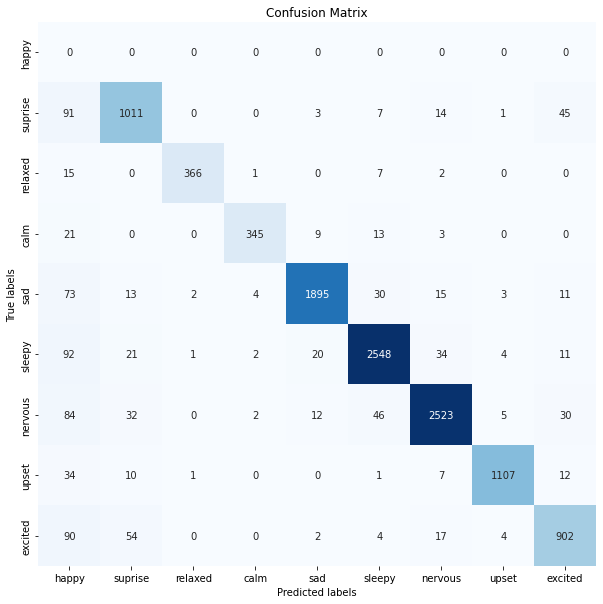

In [376]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cmatrix, annot=True,cbar=False, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["happy", "suprise", "relaxed","calm", "sad", "sleepy","nervous","upset","excited"]);
ax.yaxis.set_ticklabels(["happy", "suprise", "relaxed","calm", "sad", "sleepy","nervous","upset","excited"]);